In [1]:
from pathlib import Path
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from tqdm import tqdm
from pynumdiff.smooth_finite_difference import butterdiff
from braidz_analysis import velocity_analysis
import seaborn as sns

2026-01-14 13:14:17,233 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



## 1. Setup and Configuration

# Optogenetic Stimulation: Intensity and Duration Analysis

This notebook analyzes the relationship between optogenetic stimulation parameters (intensity and duration) and the resulting angular velocity responses in tracked animals.

## Analysis Overview
- Load braidz files containing tracking and optogenetic stimulation data
- Extract angular velocity responses around stimulation events
- Compare responses across different intensity and duration combinations
- Identify optimal stimulation parameters

In [3]:
# Analysis parameters
THRESHOLD = np.deg2rad(300)  # Threshold for peak detection in radians/s
FRAMES_BEFORE = 0  # Number of frames before stimulation
FRAMES_AFTER = 50  # Number of frames after stimulation
SAMPLING_RATE = 0.01  # seconds per frame

# Data folder and files to analyze
DATA_FOLDER = "/mnt/data/experiments"
BRAIDZ_FILES = [
    "20260106_142948.braidz",
    "20251219_143603.braidz",
    "20260107_142225.braidz",
    "20260109_154652.braidz",
    "20260108_165038.braidz",
    "20260113_162930.braidz",
]

## 2. Data Loading

In [4]:
def load_braidz_file(filepath: Path) -> tuple[pd.DataFrame | None, pd.DataFrame | None]:
    """Load kalman estimates and opto data from a braidz file."""
    try:
        with ZipFile(filepath, "r") as zip_ref:
            df = pd.read_csv(
                zip_ref.open("kalman_estimates.csv.gz"), compression="gzip", comment="#"
            )
            opto = pd.read_csv(zip_ref.open("opto.csv"))

        df["file"] = filepath.name
        opto["file"] = filepath.name
        return df, opto

    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None


# Load all braidz files
dfs = []
optos = []

for file in tqdm(BRAIDZ_FILES, desc="Loading braidz files"):
    filepath = Path(DATA_FOLDER) / file

    if not filepath.is_file():
        print(f"File {filepath} does not exist. Skipping.")
        continue

    df, opto = load_braidz_file(filepath)
    if df is not None:
        dfs.append(df)
        optos.append(opto)

# Concatenate all data
df = pd.concat(dfs, ignore_index=True)
opto = pd.concat(optos, ignore_index=True)

print(f"Loaded {len(dfs)} files with {len(opto)} optogenetic trials")

Loading braidz files:   0%|          | 0/6 [00:00<?, ?it/s]

File /mnt/data/experiments/20260106_142948.braidz does not exist. Skipping.


Loading braidz files: 100%|██████████| 6/6 [01:00<00:00, 10.10s/it]


Loaded 5 files with 166 optogenetic trials


## 3. Extract Angular Velocity Responses

For each optogenetic trial, extract the angular velocity in a window around the stimulation event.

In [32]:
results = {"angular_velocity": [], "intensity": [], "duration": [], "frames_in_light": []}

for idx, row in tqdm(opto.iterrows(), total=len(opto), desc="Processing trials"):
    # Extract metadata for this opto trial
    obj_id = int(row["obj_id"])
    frame = int(row["frame"])
    file = row["file"]
    intensity = int(row["intensity"])
    duration = int(row["duration"])

    # Calculate duration in frames (where duration is in ms)
    duration_frames = int(duration / (SAMPLING_RATE * 1000))

    # Skip sham trials
    if row["sham"]:
        continue

    # Extract relevant data from kalman estimates
    grp = df[(df["obj_id"] == obj_id) & (df["file"] == file)]
    if grp.empty:
        continue

    # Find the frame index in the trajectory
    try:
        opto_index = np.where(grp["frame"] == frame)[0][0]
    except IndexError:
        continue

    # Check if we have enough data before and after the stimulus
    if opto_index - FRAMES_BEFORE < 0 or opto_index + FRAMES_AFTER >= len(grp):
        continue

    # Extract position
    x = grp["x"].values
    y = grp["y"].values
    z = grp["z"].values

    # Get how many frames the fly was actually inside the opto light zone
    r = np.sqrt(x**2 + y**2)

    r = r[opto_index : opto_index + duration_frames]
    z = z[opto_index : opto_index + duration_frames]

    r_lim = 0.05
    z_lim = [0.01, 0.25]

    frames_in_light = np.sum((r < r_lim) & (z > z_lim[0]) & (z < z_lim[1])) / duration_frames

    # Extract and smooth velocity components
    xvel = grp["xvel"].values
    yvel = grp["yvel"].values

    xvel_smooth = savgol_filter(xvel, 21, 3)
    yvel_smooth = savgol_filter(yvel, 21, 3)

    # Calculate heading
    heading = np.arctan2(yvel_smooth, xvel_smooth)
    heading_unwrap = np.unwrap(heading)
    heading_smooth, angular_velocity = butterdiff(
        heading_unwrap,
        dt=0.01,
        params=[1, 0.1])

    # theta_smooth, theta_dot_smooth = velocity_analysis.diff_angle(
    #     grp['heading'].values,
    #     dt=0.01,
    #     params=[1, 0.1],
    #     derivative_method='smooth_finite_difference.butterdiff',
    # )
    
    # Extract window around opto stimulus
    angular_velocity_window = angular_velocity[
        opto_index - FRAMES_BEFORE : opto_index + FRAMES_AFTER
    ]

    # Store results
    results["angular_velocity"].append(np.rad2deg(angular_velocity_window))
    results["intensity"].append(intensity)
    results["duration"].append(duration)
    results["frames_in_light"].append(frames_in_light)
print(f"Successfully processed {len(results['angular_velocity'])} trials")

Processing trials:   0%|          | 0/166 [00:00<?, ?it/s]

Processing trials: 100%|██████████| 166/166 [01:53<00:00,  1.46it/s]

Successfully processed 163 trials


In [50]:
# Convert to numpy arrays for analysis
frames_in_light = np.array(results["frames_in_light"]) > 0.7

print(f"Original number of trials: {len(results['angular_velocity'])}")
print(f"Number of trials with frames_in_light > 0.5: {np.sum(frames_in_light)}")

angular_velocities = np.array(results["angular_velocity"])[frames_in_light]
durations = np.array(results["duration"])[frames_in_light]
intensities = np.array(results["intensity"])[frames_in_light]

print(f"Angular velocities shape: {angular_velocities.shape}")
print(f"Unique intensities: {np.unique(intensities)}")
print(f"Unique durations: {np.unique(durations)}")

Original number of trials: 163
Number of trials with frames_in_light > 0.5: 151
Angular velocities shape: (151, 50)
Unique intensities: [  0  51 102 153 204 255]
Unique durations: [100 200 300]


## 4. Statistical Analysis

Calculate various metrics to characterize the response strength and dynamics.

In [51]:
# Focus on first 30 frames (3 seconds) after stimulation for statistics
ANALYSIS_WINDOW = 30
abs_ang = np.abs(angular_velocities[:, :ANALYSIS_WINDOW])

# Calculate comprehensive statistics for each trial
statistics_df = pd.DataFrame({
    "intensity": intensities,
    "duration": durations,

    # Peak-based metrics
    "max_angvel": np.nanmax(abs_ang, axis=1),
    "p90_angvel": np.nanpercentile(abs_ang, 90, axis=1),
    "p95_angvel": np.nanpercentile(abs_ang, 95, axis=1),

    # Mean and variability
    "mean_angvel": np.nanmean(abs_ang, axis=1),
    "std_angvel": np.nanstd(abs_ang, axis=1),

    # Temporal structure
    "t_peak": np.nanargmax(abs_ang, axis=1),

    # Integrated response
    "auc_angvel": np.nansum(abs_ang, axis=1),

    # Early vs late response
    "mean_early": np.nanmean(abs_ang[:, :10], axis=1),
    "mean_late": np.nanmean(abs_ang[:, 10:ANALYSIS_WINDOW], axis=1),
})

# Coefficient of variation
statistics_df["cv_angvel"] = (
    statistics_df["std_angvel"] / statistics_df["mean_angvel"]
)

print(statistics_df.head())

   intensity  duration  max_angvel  p90_angvel  p95_angvel  mean_angvel  \
0        255       300  447.922052  259.205465  331.464122   107.974032   
1        255       100  100.599998   95.617691   98.661869    38.850039   
2        102       300   93.918639   78.119048   88.771670    35.753107   
3         51       300   54.842854   53.247661   54.351619    37.950226   
4        153       300  110.773327  103.316030  108.401760    53.037151   

   std_angvel  t_peak   auc_angvel  mean_early  mean_late  cv_angvel  
0  114.393508       0  3239.220962  248.372008  37.775044   1.059454  
1   34.290443      14  1165.501180   26.824524  44.862797   0.882636  
2   26.832118      16  1072.593196   33.400788  36.929266   0.750484  
3   12.848762      19  1138.506767   36.260918  38.794879   0.338569  
4   33.211686      11  1591.114525   46.241652  56.434900   0.626197  


In [44]:
# Group by intensity and duration, calculate summary statistics
grouped = (
    statistics_df
    .groupby(["intensity", "duration"])
    .agg(
        mean_max=("max_angvel", "mean"),
        median_max=("max_angvel", "median"),
        p75_max=("max_angvel", lambda x: np.percentile(x, 75)),
        mean_p90=("p90_angvel", "mean"),
        mean_auc=("auc_angvel", "mean"),
        mean_tpeak=("t_peak", "mean"),
        mean_cv=("cv_angvel", "mean"),
        n=("max_angvel", "size"),
    )
    .reset_index()
)

grouped

,intensity,duration,mean_max,median_max,p75_max,mean_p90,mean_auc,mean_tpeak,mean_cv,n
0,0,100,179.855300,114.558589,280.892601,135.018025,2201.728990,7.000000,0.642727,5
1,0,200,158.188322,158.188322,198.349291,96.266666,1537.407161,19.000000,0.707359,2
2,0,300,428.267341,428.267341,617.234670,387.931331,4789.190809,4.000000,0.938763,2
3,51,200,468.561799,343.035018,544.803557,236.172355,3128.454775,7.333333,1.078734,3
4,51,300,246.478990,186.066036,372.903158,147.402911,1975.179586,13.750000,0.787714,4
5,102,100,450.089677,450.089677,581.497893,426.373935,6795.395296,17.500000,0.494045,2
6,102,200,150.949572,150.949572,165.123876,139.010612,2542.077295,11.500000,0.468166,2
7,102,300,491.729229,529.908645,571.028526,251.808813,3464.190071,13.200000,0.883678,5
8,153,100,818.551548,764.790181,946.150509,672.104424,9179.965946,13.142857,0.796938,14
9,153,200,637.473490,471.392189,769.013011,530.295904,7499.470813,17.187500,0.730175,16


### 4.1 Group Statistics by Condition

Aggregate statistics across trials for each intensity-duration combination.

In [45]:
# Best by robust peak response (75th percentile)
best_peak = grouped.loc[grouped["p75_max"].idxmax()]
print("Best by robust peak response (75th percentile):")
print(f"  Intensity: {best_peak['intensity']:.0f}")
print(f"  Duration: {best_peak['duration']:.0f} ms")
print(f"  75th percentile max: {best_peak['p75_max']:.1f} deg/s")
print(f"  n={best_peak['n']:.0f} trials\n")

Best by robust peak response (75th percentile):
  Intensity: 204
  Duration: 200 ms
  75th percentile max: 1946.5 deg/s
  n=12 trials



2026-01-14 14:08:37,046 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-14 14:08:37,054 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-14 14:08:37,131 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-14 14:08:37,138 [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


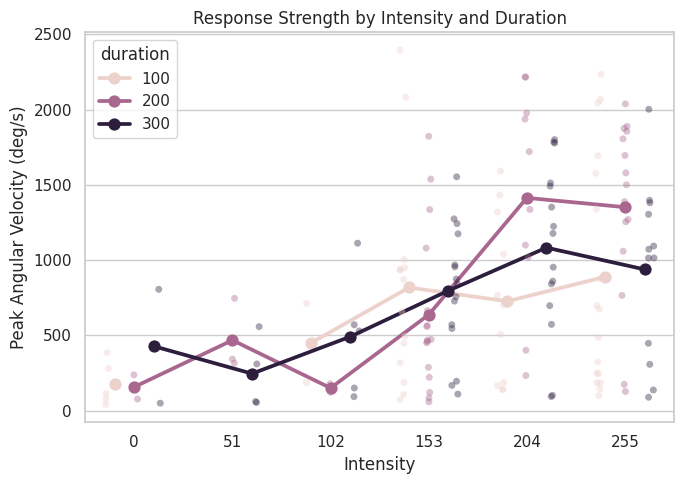

In [57]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(7, 5))

# Show individual trials as semi-transparent points
sns.stripplot(
    data=statistics_df,
    x="intensity",
    y="max_angvel",
    hue="duration",
    dodge=True,
    alpha=0.4,
    ax=ax,
    legend=False,
)

# Overlay mean response
sns.pointplot(
    data=statistics_df,
    x="intensity",
    y="max_angvel",
    hue="duration",
    estimator=np.mean,
    errorbar=None,
    dodge=0.4,
    markers="o",
    linestyles="-",
    ax=ax,
    legend=True,
)

ax.set_xlabel("Intensity")
ax.set_ylabel("Peak Angular Velocity (deg/s)")
ax.set_title("Response Strength by Intensity and Duration")
plt.tight_layout()
plt.show()

## 5. Visualization

### 5.1 Response Distribution by Intensity and Duration

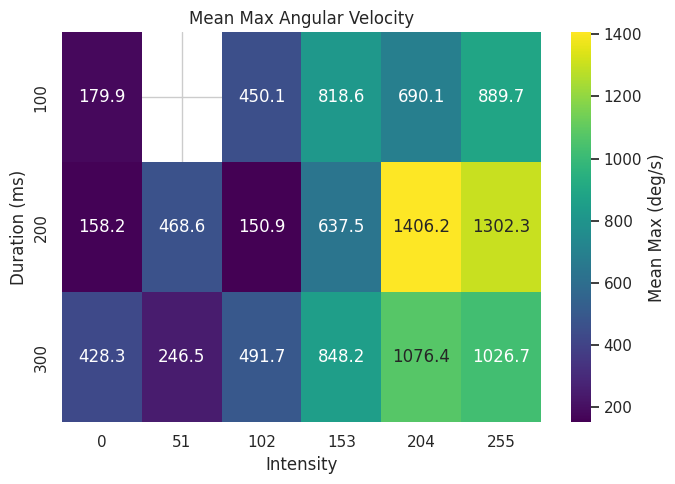

In [60]:
# Create pivot table for heatmap
pivot_peak = grouped.pivot(
    index="duration", columns="intensity", values="mean_max"
)

plt.figure(figsize=(7, 5))
sns.heatmap(pivot_peak, annot=True, fmt=".1f", cmap="viridis", cbar_kws={"label": "Mean Max (deg/s)"})
plt.title("Mean Max Angular Velocity")
plt.ylabel("Duration (ms)")
plt.xlabel("Intensity")
plt.tight_layout()
plt.show()

### 5.2 Heatmap of Peak Responses

In [61]:
# Organize data by duration and intensity for time-series plotting
data = {}

for duration in np.sort(np.unique(durations)):
    data[duration] = {}

    for intensity in np.sort(np.unique(intensities)):
        mask = (intensities == intensity) & (durations == duration)
        data[int(duration)][int(intensity)] = angular_velocities[mask]

### 5.3 Time Series Analysis

Organize data by condition for time-series plotting.

/tmp/ipykernel_472561/512181732.py:30: RuntimeWarning: Mean of empty slice.
  mean = np.abs(traces).mean(axis=0)
/home/nfc/src/braidz_analysis/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/nfc/src/braidz_analysis/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/nfc/src/braidz_analysis/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/nfc/src/braidz_analysis/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:212: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


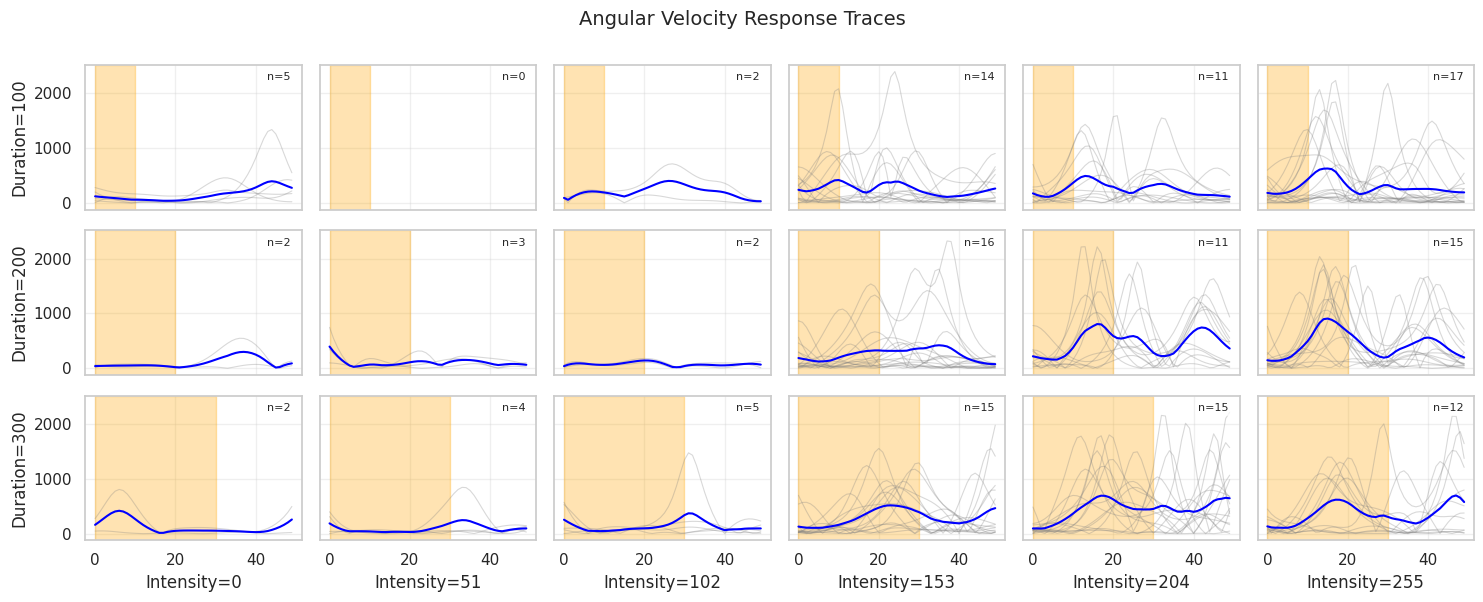

In [65]:
# Get sorted unique values for consistent ordering
durations_sorted = sorted(data.keys())
intensities_sorted = sorted(data[durations_sorted[0]].keys())

n_durations = len(durations_sorted)
n_intensities = len(intensities_sorted)

fig, axes = plt.subplots(
    n_durations,
    n_intensities,
    figsize=(n_intensities * 2.5, n_durations * 2),
    sharex=True,
    sharey=True,
)

# Handle case where axes isn't 2D
if n_durations == 1:
    axes = axes.reshape(1, -1)
if n_intensities == 1:
    axes = axes.reshape(-1, 1)

for i, duration in enumerate(durations_sorted):
    for j, intensity in enumerate(intensities_sorted):
        ax = axes[i, j]

        # Get traces for this condition
        traces = data[duration][intensity]

        # Compute mean and std across trials
        mean = np.abs(traces).mean(axis=0)
        std = np.abs(traces).std(axis=0)
        x = np.arange(len(mean))

        # # Plot mean ± std
        # ax.plot(x, mean, linewidth=1.5)
        # ax.fill_between(x, mean - std, mean + std, alpha=0.3)
        # Plot individual traces
        for trace in traces:
            ax.plot(np.abs(trace), color="gray", alpha=0.3, linewidth=0.8)
        ax.plot(mean, color="blue", linewidth=1.5)
        ax.axvspan(
            FRAMES_BEFORE,
            FRAMES_BEFORE + int(duration / (SAMPLING_RATE * 1000)),
            color="orange",
            alpha=0.3,
        )
        # Add trial count
        n_traces = traces.shape[0]
        ax.text(
            0.95, 0.95, f"n={n_traces}",
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7),
        )

        # Labels only on edges
        if i == n_durations - 1:
            ax.set_xlabel(f"Intensity={intensity}")
        if j == 0:
            ax.set_ylabel(f"Duration={duration}")

        ax.grid(True, alpha=0.3)

fig.suptitle("Angular Velocity Response Traces", fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

#### Grid of Response Traces

Show mean ± std of angular velocity traces for all condition combinations.

/tmp/ipykernel_472561/971821013.py:15: RuntimeWarning: Mean of empty slice.
  mean = np.abs(traces).mean(axis=0)


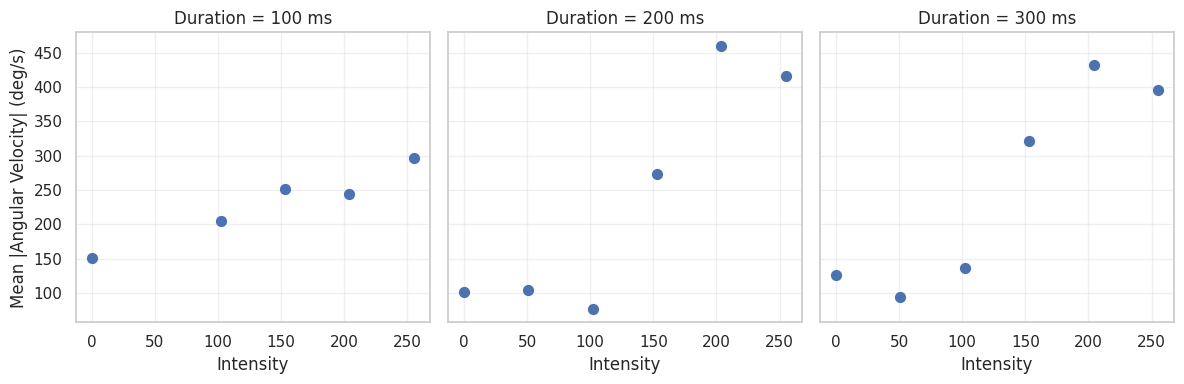

In [17]:
fig, axes = plt.subplots(1, n_durations, figsize=(n_durations * 4, 4), sharey=True)

if n_durations == 1:
    axes = [axes]

for i, duration in enumerate(durations_sorted):
    ax = axes[i]

    # Collect mean responses across intensities
    all_means = []
    intensity_labels = []

    for intensity in intensities_sorted:
        traces = data[duration][intensity]
        mean = np.abs(traces).mean(axis=0)
        all_means.append(mean.mean())
        intensity_labels.append(intensity)

    # Plot
    ax.scatter(intensity_labels, all_means, s=50)
    ax.set_xlabel("Intensity")
    ax.set_title(f"Duration = {duration:.0f} ms")
    
    if i == 0:
        ax.set_ylabel("Mean |Angular Velocity| (deg/s)")
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Response vs Intensity (by Duration)

/tmp/ipykernel_381244/1297579676.py:15: RuntimeWarning: Mean of empty slice.
  mean = np.abs(traces).mean(axis=0)


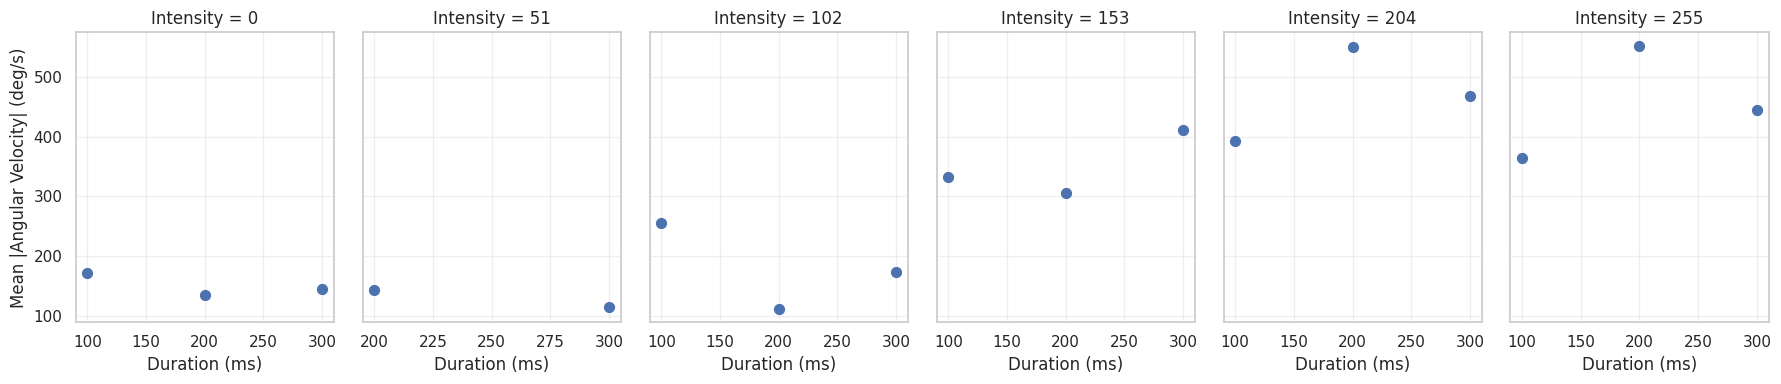

In [16]:
fig, axes = plt.subplots(1, n_intensities, figsize=(n_intensities * 3, 4), sharey=True)

if n_intensities == 1:
    axes = [axes]

for j, intensity in enumerate(intensities_sorted):
    ax = axes[j]

    # Collect mean responses across durations
    all_means = []
    duration_labels = []

    for duration in durations_sorted:
        traces = data[duration][intensity]
        mean = np.abs(traces).mean(axis=0)
        all_means.append(mean.mean())
        duration_labels.append(duration)

    # Plot
    ax.scatter(duration_labels, all_means, s=50)
    ax.set_xlabel("Duration (ms)")
    ax.set_title(f"Intensity = {intensity:.0f}")
    
    if j == 0:
        ax.set_ylabel("Mean |Angular Velocity| (deg/s)")
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Response vs Duration (by Intensity)